# PFHub BM 1a in FiPy with Steppyngstounes

This notebook implements [PFHub] Benchmark [1a][spinodal] using [FiPy] and [steppyngstounes].
It also explores alternative initial conditions that are more-periodic than the specification.

<!-- links -->
[FiPy]: https://www.ctcms.nist.gov/fipy
[spinodal]: https://pages.nist.gov/pfhub/benchmarks/benchmark1.ipynb/#(a)-Square-periodic
[steppyngstounes]: https://github.com/usnistgov/steppyngstounes
[PFHub]: https://pages.nist.gov/pfhub/

### Warning!

This code will consume up to 4 GB of RAM per step, which quickly accumulates. Proceed with caution!

In [1]:
%matplotlib inline

import gc
import os
import pandas
import psutil
import time

from IPython.display import display, update_display

from fipy import FaceVariable, CellVariable
from fipy import DiffusionTerm, ImplicitSourceTerm, TransientTerm
from fipy import numerix, parallel, Viewer

# from fipy import Grid2D
from fipy import PeriodicGrid2D as Grid2D

from fipy.solvers.petsc import LinearLUSolver as Solver
from fipy.solvers.petsc.comms import petscCommWrapper

from math import ceil, log10

from steppyngstounes import CheckpointStepper, PIDStepper

In [2]:
try:
    startTime = time.time_ns()
    time_has_ns = True
except AttributeError:
    startTime = time.time()
    time_has_ns = False

cos  = numerix.cos
pi   = numerix.pi
    
proc = psutil.Process()

comm = petscCommWrapper.PETScCommWrapper()
rank = parallel.procID

def mprint(*args, **kwargs):
    if rank == 0:
        print(*args, **kwargs)

## Prepare mesh & phase field

In [3]:
nx = ny = 200
dx = dy = 0.3125  # 640×640

mesh = Grid2D(nx=nx, ny=ny, dx=dx, dy=dy)
x, y = mesh.cellCenters

c = CellVariable(mesh=mesh, name=r"$c$",   hasOld=True)
μ = CellVariable(mesh=mesh, name=r"$\mu$", hasOld=True)

### Set thermo-kinetic constants from the BM1 specification

In [4]:
α = 0.3
β = 0.7
ρ = 5
κ = 2
M = 5

t = 0.0
dt = 1e-5
fin = 0.05

# Write to disk every 1, 2, 5, 10, 20, 50, ...
chkpts = [float(p * 10**q) \
          for q in range(-3, ceil(log10(fin + 1.0e-6))) \
          for p in (1, 2, 5)]

## Define equations of motion

This is based on [fipy.examples.cahnHilliard.mesh2DCoupled],
using a first-order Taylor series substitution in place of the bulk free energy "source term".
The coupled equations are

$$
\frac{\partial c}{\partial t} = \nabla \cdot M\nabla\mu
$$

$$
\mu = \left(\frac{\partial f_{\mathrm{bulk}}}{\partial c} - \frac{\partial^2 f_{\mathrm{bulk}}}{\partial c^2} \cdot c\right)_{\mathrm{old}} + \frac{\partial^2 f_{\mathrm{bulk}}}{\partial c^2}\cdot c - \kappa \nabla^2 c
$$

where the second term on $\mu$ is an `ImplicitSourceTerm` and the last is a `DiffusionTerm`.

[fipy.examples.cahnHilliard.mesh2DCoupled]: https://www.ctcms.nist.gov/fipy/examples/cahnHilliard/generated/examples.cahnHilliard.mesh2DCoupled.html

In [5]:
# ## Uncomment and run this cell to double-check the derivatives.

# import sympy.abc
# from sympy import Eq, diff, expand, factor, symbols
# fbulk = sympy.abc.rho * (sympy.abc.c - sympy.abc.alpha)**2 \
#                       * (sympy.abc.beta - sympy.abc.c)**2

# display(Eq(symbols("f"), fchem))
# display(Eq(symbols("f'"), factor(diff(fchem,
#                                       sympy.abc.c))))
# display(Eq(symbols("f''"), factor(expand(diff(fbulk,
#                                              sympy.abc.c,
#                                              sympy.abc.c)))))

The free energy density and its first two derivatives are (refactored after SymPy)

$$f_{\mathrm{bulk}} = \rho (c - \alpha)^2 (\beta - c)^2$$

$$f'_{\mathrm{bulk}} = 2\rho (c - \alpha)(\beta - c)(\alpha - 2c + \beta)$$

$$f''_{\mathrm{bulk}} = 2\rho\left\{\alpha^2 + 4 \alpha \beta + \beta^2 - 6 c \left(\alpha - c + \beta\right)\right\}$$

In [6]:
fbulk = ρ * (c - α)**2 * (β - c)**2
d1fdc = 2 * ρ * (c - α) * (β - c) * (α - 2 * c + β)
d2fdc = 2 * ρ * (α**2 + 4*α*β + β**2 - 6 * c * (α - c + β))

In [7]:
eom_c = TransientTerm(var=c) == DiffusionTerm(coeff=M, var=μ)

eom_μ = ImplicitSourceTerm(coeff=1.0, var=μ) \
     == (d1fdc - d2fdc * c) \
      + ImplicitSourceTerm(coeff=d2fdc, var=c) \
      - DiffusionTerm(coeff=κ, var=c)

eom = eom_c & eom_μ

## Initial Conditions -- As Specified

In [8]:
iodir = "orig"

if not os.path.exists(iodir):
    os.mkdir(iodir)

In [9]:
c0 = 0.5
ϵ = 0.01

def initialize(A, B):
    return c0 + ϵ * (
           cos(A[0] * x) * cos(B[0] * y) \
        + (cos(A[1] * x) * cos(B[1] * y))**2 \
        +  cos(A[2] * x  +     B[2] * y) \
        *  cos(A[3] * x  +     B[3] * y)
    )

In [10]:
# BM 1a specification: not periodic at all

A0 = [0.105, 0.130, 0.025, 0.070]
B0 = [0.110, 0.087,-0.150,-0.020]

c.value = initialize(A0, B0)
μ.value = d1fdc[:]

c.updateOld()
μ.updateOld()

## Prepare free energy output

In [11]:
df = None

labs = [
    "wall_time", 
    "time",     
    "free_energy",
    "mem_GB",    
    "timestep", 
    "mass"
]

if rank == 0:  # write the CSV header
    fcsv = "{}/energy.csv".format(iodir)
    with open(fcsv, "w") as fh:
        fh.write("{},{},{},{},{},{}\n".format(*labs))
else:
    fcsv = None

def update_energy(fh=None):
    # Integration of fields: CellVolumeAverage, .sum(), 
    nrg = (fbulk - 0.5 * κ * numerix.dot(c.grad, c.grad)).sum()
    mas = c.sum()
    mem = comm.allgather(proc.memory_info().rss) / 1024**3
    if rank == 0:
        if time_has_ns:
            timer = 1e-9 * (time.time_ns() - startTime)
        else:
            timer = time.time() - startTime
    
        vals = [timer, t, nrg, mem, dt, mas]
        
        with open(fcsv, "a") as fh:
            fh.write("{},{},{},{},{},{}\n".format(*vals))
        
update_energy(fcsv)

## Timestepping

In [12]:
rtol = 1e-3
solver = Solver()

mprint("Writing a checkpoint at the following times:")
mprint(chkpts)

Writing a checkpoint at the following times:
[0.001, 0.002, 0.005, 0.01, 0.02, 0.05]


/Valhalla/opt/anaconda/envs/fipy/lib/python3.9/site-packages/fipy/viewers/matplotlibViewer/matplotlibViewer.py:123: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  self._colorbar = self.fig.colorbar(mappable=self._mappable,
/Valhalla/opt/anaconda/envs/fipy/lib/python3.9/site-packages/fipy/viewers/matplotlibViewer/matplotlib2DViewer.py:102: MatplotlibDeprecationWarning: Passing argument *p* of unexpected type PolyCollection to add_patch which only accepts <class 'matplotlib.patches.Patch'> is deprecated since 3.5 and will become an error two minor releases later.
  self.axes.add_patch(self.collection)
/Valhalla/opt/anaconda/envs/fipy/lib/python3.9/site-packages/matplotlib/_mathtext.py:1871: UserWarning: warn_name_set_on_empty_Forward: setting results name 'sy

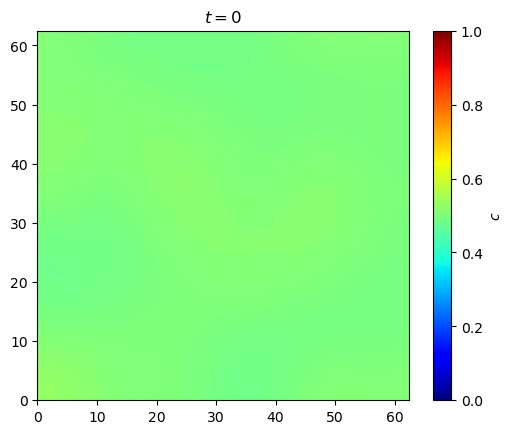

In [13]:
viewer = Viewer(vars=(c,), 
                title="$t = 0$",
                datamin=0., datamax=1.)

In [14]:
def stepper(check):
    global dt
    global t
    for step in PIDStepper(start=check.begin,
                           stop=check.end,
                           size=dt):
        mprint("    Stepping [{:12g} .. {:12g}) / {:12g}".format(float(step.begin),
                                                                 float(step.end),
                                                                 float(step.size)),
               end=" ")

        for sweep in range(2):
            res = eom.sweep(dt=step.size, solver=solver)

        if step.succeeded(error=res/rtol):
            mprint("✔")
            dt = step.size
            t += dt
            c.updateOld()
            μ.updateOld()
            update_energy(fcsv)
        else:
            mprint("✘")
            c.value = c.old
            μ.value = μ.old

        gc.collect()

    dt = step.want
    
    viewer.title=r"$t = %12g$" % t
    viewer.plot()

In [15]:
def checkers():
    global dt
    global t
    for check in CheckpointStepper(start=0.0,
                                   stops=chkpts,
                                   stop=fin):
        mprint("Launching [{:12g} .. {:12g})".format(check.begin,
                                                     check.end))

        stepper(check)

        _ = check.succeeded()

        gc.collect()

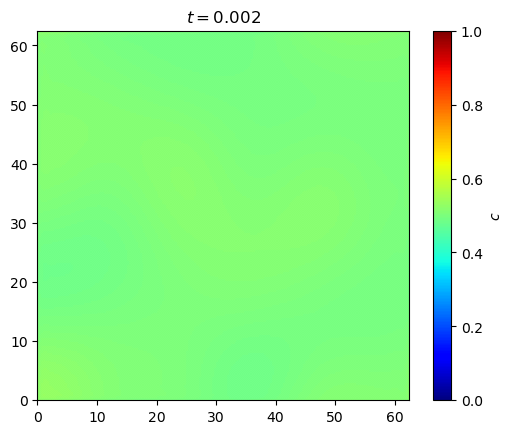

Launching [       0.002 ..        0.005)
    Stepping [       0.002 ..   0.00231569) /   0.00031569 ✔
    Stepping [  0.00231569 ..   0.00271869) /     0.000403 ✔
    Stepping [  0.00271869 ..   0.00317736) /  0.000458667 ✔
    Stepping [  0.00317736 ..   0.00371093) /  0.000533576 

In [ ]:
checkers()

In [ ]:
df = pandas.read_csv("{}/energy.csv".format(iodir))
df